## リファクタリング

In [3]:
import azure.ai.ml 
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azureml.core import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')


try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    # This will open a browser page for
    credential = InteractiveBrowserCredential()

try:
    ml_client = MLClient.from_config(credential=credential)
except Exception as ex:
    # NOTE: Update following workspace information if not correctly configure before
    client_config = {
        "subscription_id": ws.subscription_id,
        "resource_group": ws.resource_group,
        "workspace_name": ws.name,
    }

    if client_config["subscription_id"].startswith("<"):
        print(
            "please update your <SUBSCRIPTION_ID> <RESOURCE_GROUP> <AML_WORKSPACE_NAME> in notebook cell"
        )
        raise ex
    else:  # write and reload from config file
        import json, os

        config_path = "../.azureml/config.json"
        os.makedirs(os.path.dirname(config_path), exist_ok=True)
        with open(config_path, "w") as fo:
            fo.write(json.dumps(client_config))
        ml_client = MLClient.from_config(credential=credential, path=config_path)
print(ml_client)

Workspace name: skilling-ml-sand
Azure region: japaneast
Subscription id: aa7533c4-42d3-4f74-9b7e-9bec680a7c22
Resource group: vse-rg-sand
MLClient(credential=<azure.identity._credentials.default.DefaultAzureCredential object at 0x7f9268885b80>,
         subscription_id=aa7533c4-42d3-4f74-9b7e-9bec680a7c22,
         resource_group_name=vse-rg-sand,
         workspace_name=skilling-ml-sand)


In [4]:
import mlflow

tracking_uri = ml_client.workspaces.get(name=ws.name).mlflow_tracking_uri
mlflow.set_tracking_uri(tracking_uri)
experiment_name = "skill-train-evaluate-regression-models" 
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='', experiment_id='65681a56-c343-4d34-8f3f-f985deeb62f8', lifecycle_stage='active', name='skill-train-evaluate-regression-models', tags={}>

### Step 1 とりあえずまとめる

In [ ]:


import pandas as pd
file_path = './data/daily-bike-share.csv'
bike_data = pd.read_csv(file_path)
bike_data.head()

# Dataprep
# enable auto logging
mlflow.autolog()
# Separate features and labels
X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values
print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')


from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

# Train

# Train the model
from sklearn.linear_model import LinearRegression

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
print (model)

# Evaluate

import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')

mlflow.log_figure(fig,"evaluate.png")

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

metric = {
    "MSE": mse,
    "RMSE":rmse,
    "R2":r2
}
mlflow.log_metrics(metric)

### Step2 機械的に関数にする

In [ ]:


import pandas as pd
file_path = './data/daily-bike-share.csv'
bike_data = pd.read_csv(file_path)
bike_data.head()


# Dataprep

def data_prep():
    # enable auto logging
    mlflow.autolog()
    # Separate features and labels
    X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values
    print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')


    from sklearn.model_selection import train_test_split

    # Split data 70%-30% into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

    print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

# Train
def train_mode():



    # Train the model
    from sklearn.linear_model import LinearRegression

    # Fit a linear regression model on the training set
    model = LinearRegression().fit(X_train, y_train)
    print (model)

# Evaluate
def evaluate_model():

    import numpy as np

    predictions = model.predict(X_test)
    np.set_printoptions(suppress=True)
    print('Predicted labels: ', np.round(predictions)[:10])
    print('Actual labels   : ' ,y_test[:10])


    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_test, predictions)
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Daily Bike Share Predictions')
    # overlay the regression line
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')

    mlflow.log_figure(fig,"evaluate.png")

    from sklearn.metrics import mean_squared_error, r2_score

    mse = mean_squared_error(y_test, predictions)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

    r2 = r2_score(y_test, predictions)
    print("R2:", r2)

    metric = {
        "MSE": mse,
        "RMSE":rmse,
        "R2":r2
    }
    mlflow.log_metrics(metric)

### Step 3 パラメータを整理する
- 関数内で定義されていないものを引数にする

In [ ]:


import pandas as pd
file_path = './data/daily-bike-share.csv'
bike_data = pd.read_csv(file_path)
bike_data.head()


# Dataprep
def data_prep(bike_data):
    # enable auto logging
    mlflow.autolog()
    # Separate features and labels
    X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values
    print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')


    from sklearn.model_selection import train_test_split

    # Split data 70%-30% into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

    print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

    
# Train
def train_mode(X_train, y_train):

    # Train the model
    from sklearn.linear_model import LinearRegression

    # Fit a linear regression model on the training set
    model = LinearRegression().fit(X_train, y_train)
    print (model)

# Evaluate
def evaluate_model(model,X_test,y_test):

    import numpy as np

    predictions = model.predict(X_test)
    np.set_printoptions(suppress=True)
    print('Predicted labels: ', np.round(predictions)[:10])
    print('Actual labels   : ' ,y_test[:10])


    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_test, predictions)
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Daily Bike Share Predictions')
    # overlay the regression line
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')

    mlflow.log_figure(fig,"evaluate.png")

    from sklearn.metrics import mean_squared_error, r2_score

    mse = mean_squared_error(y_test, predictions)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

    r2 = r2_score(y_test, predictions)
    print("R2:", r2)

    metric = {
        "MSE": mse,
        "RMSE":rmse,
        "R2":r2
    }
    mlflow.log_metrics(metric)

### Step 4  mainを作成し、整える。

- mainと実行を組む
- returnを実装する.
- mlflowをまとめて、start_run()を組みこむ
- import など整理する　※mlflow忘れないように
- ここでデバッグ可能になる

2022/06/24 07:54:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/06/24 07:54:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/06/24 07:54:41 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2022/06/24 07:54:41 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2022/06/24 07:54:41 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                       ...

Features:
[[1.        1.        0.        6.        0.        2.        0.344167
  0.363625  0.805833  0.160446 ]
 [1.        1.        0.        0.        0.        2.        0.363478
  0.353739  0.696087  0.248539 ]
 [1.        1.        0.        1.        1.        1.        0.196364
  0.189405  0.437273  0.248309 ]
 [1.        1.        0.        2.        1.        1.        0.2
  0.212122  0.590435  0.160296 ]
 [1.        1.        0.        3.        1.        1.        0.226957
  0.22927   0.436957  0.1869   ]
 [1.        1.        0.        4.        1.        1.        0.204348
  0.233209  0.518261  0.0895652]
 [1.        1.        0.        5.        1.        2.        0.196522
  0.208839  0.498696  0.168726 ]
 [1.        1.        0.        6.        0.        2.        0.165
  0.162254  0.535833  0.266804 ]
 [1.        1.        0.        0.        0.        1.        0.138333
  0.116175  0.434167  0.36195  ]
 [1.        1.        0.        1.        1.        1.        

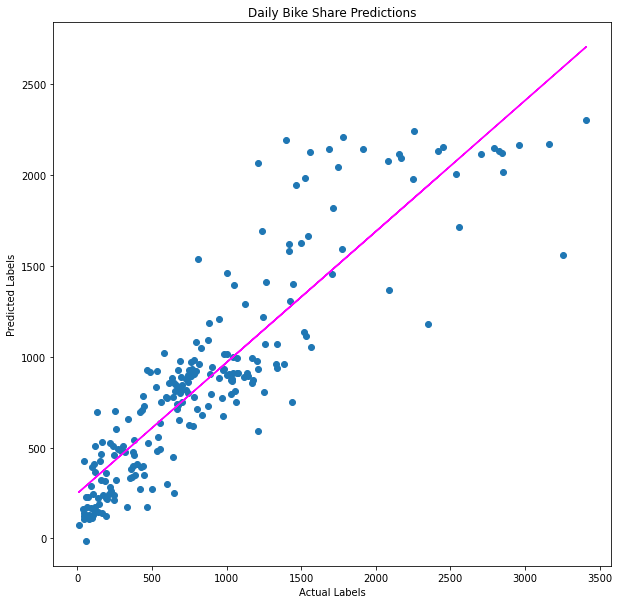

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def main():

    # enable auto logging
    mlflow.autolog()
    
    file_path = './data/daily-bike-share.csv'
    bike_data = pd.read_csv(file_path)
    bike_data.head()

    X_train, X_test, y_train, y_test = data_prep(bike_data)

    model = train_mode(X_train, y_train)

    evaluate = evaluate_model(model,X_test,y_test)


# Dataprep
def data_prep(bike_data):

    # Separate features and labels
    X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values
    print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

    # Split data 70%-30% into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
    print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

    return X_train, X_test, y_train, y_test
    
# Train
def train_mode(X_train, y_train):

    # Train the model
    # Fit a linear regression model on the training set
    model = LinearRegression().fit(X_train, y_train)
    print (model)

    return model

# Evaluate
def evaluate_model(model,X_test,y_test):

    predictions = model.predict(X_test)
    np.set_printoptions(suppress=True)
    print('Predicted labels: ', np.round(predictions)[:10])
    print('Actual labels   : ' ,y_test[:10])
    
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_test, predictions)
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Daily Bike Share Predictions')
    # overlay the regression line
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')

    mlflow.log_figure(fig,"evaluate.png")

    mse = mean_squared_error(y_test, predictions)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

    r2 = r2_score(y_test, predictions)
    print("R2:", r2)

    metric = {
        "MSE": mse,
        "RMSE":rmse,
        "R2":r2
    }
    mlflow.log_metrics(metric)

    return metric
    
if __name__ == "__main__":
    # run main function
    main()

Step 5 コードにargを作成し、main.pyを作成する

In [4]:
import os

src_dir = "./src"
os.makedirs(src_dir, exist_ok=True)

In [ ]:
%%writefile ./src/main.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import argparse # 追加

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def main(args):
    
    # enable auto logging
    mlflow.autolog()

    # file_path = './data/daily-bike-share.csv'
    bike_data = pd.read_csv(args.input_data)
    bike_data.head()

    X_train, X_test, y_train, y_test = data_prep(bike_data)

    model = train_mode(X_train, y_train)

    evaluate = evaluate_model(model,X_test,y_test)


# Dataprep
def data_prep(bike_data):

    # Separate features and labels
    X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values
    print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

    # Split data 70%-30% into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
    print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

    return X_train, X_test, y_train, y_test
    
# Train
def train_mode(X_train, y_train):

    # Train the model
    # Fit a linear regression model on the training set
    model = LinearRegression().fit(X_train, y_train)
    print (model)

    return model

# Evaluate
def evaluate_model(model,X_test,y_test):

    predictions = model.predict(X_test)
    np.set_printoptions(suppress=True)
    print('Predicted labels: ', np.round(predictions)[:10])
    print('Actual labels   : ' ,y_test[:10])
    
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_test, predictions)
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Daily Bike Share Predictions')
    # overlay the regression line
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')

    mlflow.log_figure(fig,"evaluate.png")

    mse = mean_squared_error(y_test, predictions)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

    r2 = r2_score(y_test, predictions)
    print("R2:", r2)

    metric = {
        "MSE": mse,
        "RMSE":rmse,
        "R2":r2
    }
    mlflow.log_metrics(metric)

    return metric
    
def parse_args():
   
    # setup arg parser
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_data", type=str)

    args = parser.parse_args()

    # return args
    return args


# run script
if __name__ == "__main__":
    # parse args
    args = parse_args()

    # run main function
    main(args)

## 以下で作業

In [28]:
%%writefile ./src/main.py


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import argparse # 追加
import azureml.mlflow

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# enable auto logging
mlflow.autolog()

def main(args):

    with mlflow.start_run() as run:
        # file_path = './data/daily-bike-share.csv'
        bike_data = pd.read_csv(args.input_data)
        # bike_data.head()

        # Try these hyperparameter values

        params = {
            'regressor__n_estimators': list(range(20, 101, 10)),
            'regressor__learning_rate': list(np.arange(0.05, 0.20, 0.01))
            }
        mlflow.log_params(params)

        X_train, X_test, y_train, y_test = data_prep(bike_data)
        model = train_model(X_train, y_train,params)
        metric ,fig  = evaluate_model(model,X_test,y_test)

        mlflow.log_figure(fig,"evaluate.png")
        mlflow.log_metrics(metric)

        
# Dataprep
def data_prep(bike_data):

    # Separate features and labels
    X, y = bike_data[['season','mnth', 'holiday','weekday','workingday','weathersit','temp', 'atemp', 'hum', 'windspeed']].values, bike_data['rentals'].values
    print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

    # Split data 70%-30% into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
    print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

    return X_train, X_test, y_train, y_test
    
# Train

def train_model(X_train, y_train,params):

    # Train the model


    # Define preprocessing for numeric columns (scale them)
    numeric_features = [6,7,8,9]
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    # Define preprocessing for categorical features (encode them)
    categorical_features = [0,1,2,3,4,5]
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    # Create preprocessing and training pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', GradientBoostingRegressor())])

    score = make_scorer(r2_score)
    gridsearch = GridSearchCV(pipeline, params, scoring=score, cv=3, return_train_score=True)
    gridsearch.fit(X_train, y_train)
    model = gridsearch.best_estimator_

    print("Best parameter combination:", gridsearch.best_params_, "\n")

    print (model)

    return model

# Evaluate
def evaluate_model(model,X_test,y_test):

    predictions = model.predict(X_test)
    np.set_printoptions(suppress=True)
    print('Predicted labels: ', np.round(predictions)[:10])
    print('Actual labels   : ' ,y_test[:10])
    
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_test, predictions)
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Daily Bike Share Predictions')
    # overlay the regression line
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
   
    mse = mean_squared_error(y_test, predictions)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

    r2 = r2_score(y_test, predictions)
    print("R2:", r2)

    metric = {
        "MSE": mse,
        "RMSE":rmse,
        "R2":r2
    }
    
    return metric , fig
    
def parse_args():
   
    # setup arg parser
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_data", type=str)

    args = parser.parse_args()

    # return args
    return args

# run script
if __name__ == "__main__":
    # parse args
    args = parse_args()

    # run main function
    main(args)


Overwriting ./src/main.py
